In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=Warning)


Bad key "text.kerning_factor" on line 4 in
C:\Users\chimd\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df2 = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df2.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

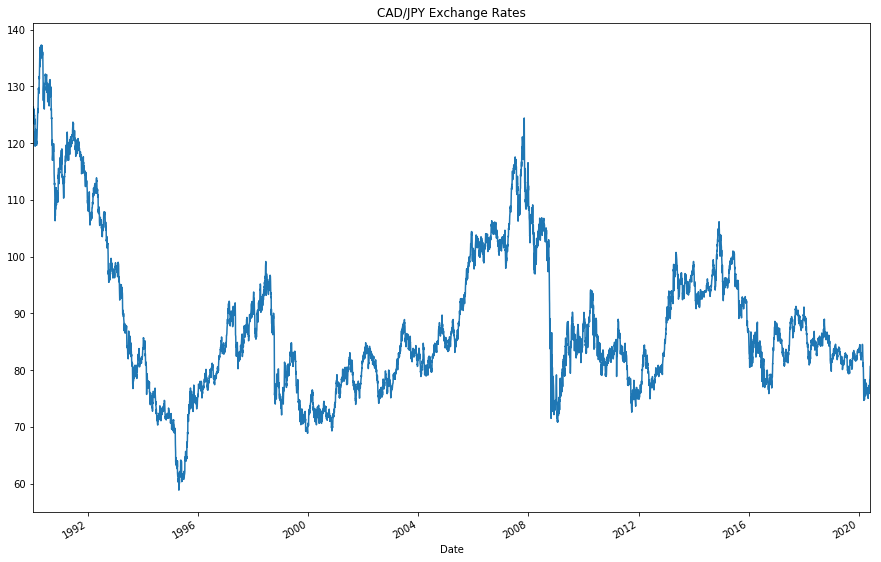

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df2.Price.plot(title='CAD/JPY Exchange Rates', figsize=(15,10))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** I see a plot fairly stable in the long-term around 80 though there are periods almost cyclical where it is above for about 3 years. 

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
exchange_noise, exchange_trend = sm.tsa.filters.hpfilter(cad_jpy_df2['Price'])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
#drop all other columns
cad_jpy_df3 = cad_jpy_df2.drop('Open', axis = 1)
cad_jpy_df4 = cad_jpy_df3.drop('High', axis = 1)
cad_jpy_df5 = cad_jpy_df4.drop('Low', axis = 1)
cad_jpy_df5['Noise'] = exchange_noise
cad_jpy_df5['Trend'] = exchange_trend
cad_jpy_df5.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


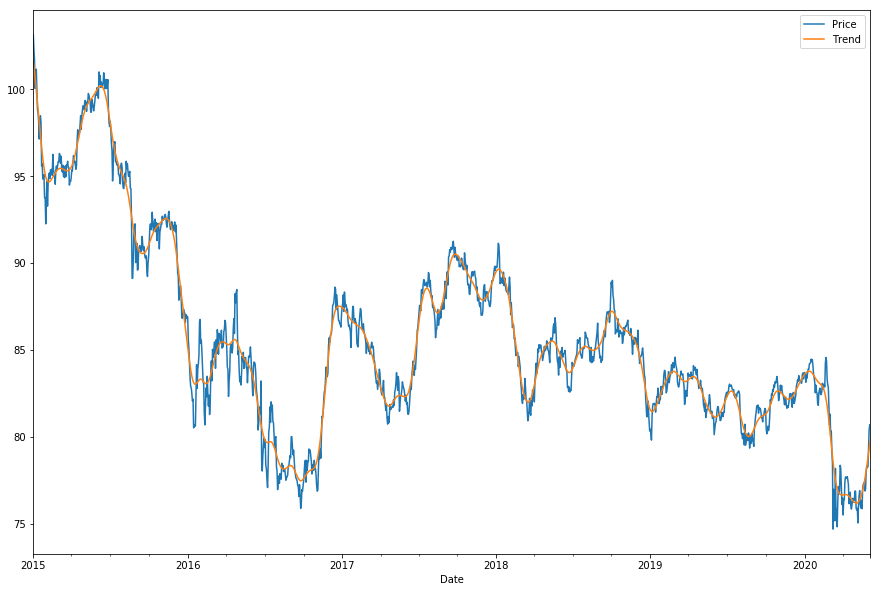

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_df6 = cad_jpy_df5.loc['2015':]
cad_jpy_df6.drop('Noise', axis=1).plot(legend=True, figsize=(15,10))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** I see a general decline in price longterm.

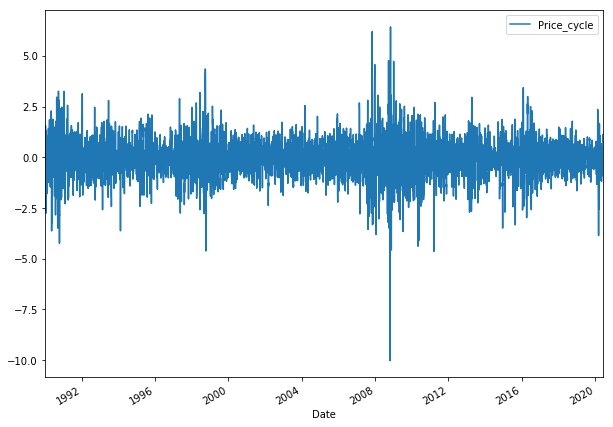

In [8]:
# Plot the Settle Noise
exchange_noise.plot(figsize=(10,7.5), legend=True)

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.Price, order=(2,1))

In [11]:
# Fit the model and assign it to a variable called results
results = model.fit()

In [12]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 9965
Model:                     ARMA(2, 1)   Log Likelihood              -11924.111
Method:                       css-mle   S.D. of innovations              0.801
Date:                Fri, 30 Apr 2021   AIC                          23858.222
Time:                        08:30:38   BIC                          23894.256
Sample:                             0   HQIC                         23870.421
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0051      0.008     -0.649      0.517      -0.020       0.010
ar.L1.Price    -0.8439      0.204     -4.129      0.000      -1.244      -0.443
ar.L2.Price    -0.0161      0.012     -1.334      0.182      -0.040       0.008
ma.L1.Price     0.8201      0.204      4.018      0.000       0.420       1.220
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2130           +0.0000j            1.2130            0.5000
AR.2          -51.3646           +0.0000j           51.3646            0.5000
MA.1           -1.2193           +0.0000j            1.2193            0.5000
-----------------------------------------------------------------------------
"""

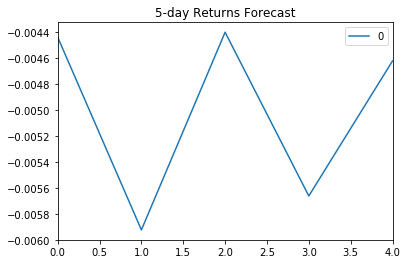

In [13]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps = 5)[0]).plot(title='5-day Returns Forecast')

**Question:** Based on the p-value, is the model a good fit?

**Answer:** The model seems good as most p-values are < 0.05 except for the ar.L2.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model1 = ARIMA(cad_jpy_df.Price, order=(5,1,1))

In [15]:
# Fit the model
outcome1 = model1.fit()

In [16]:
# Output model summary results:
outcome1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 9965
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -11737.114
Method:                       css-mle   S.D. of innovations              0.786
Date:                Fri, 30 Apr 2021   AIC                          23490.229
Time:                        08:30:42   BIC                          23547.884
Sample:                             1   HQIC                         23509.748
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0104      0.008     -1.281      0.200      -0.026       0.006
ar.L1.D.Price    -0.4652      0.374     -1.245      0.213      -1.198       0.267
ar.L2.D.Price     0.0080      0.011      0.696      0.486      -0.015       0.030
ar.L3.D.Price     0.0137      0.012      1.151      0.250      -0.010       0.037
ar.L4.D.Price     0.0187      0.011      1.629      0.103      -0.004       0.041
ar.L5.D.Price     0.0143      0.011      1.325      0.185      -0.007       0.035
ma.L1.D.Price     0.4568      0.374      1.223      0.221      -0.275       1.189
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9826           -0.6603j            2.0896           -0.4488
AR.2           -1.9826           +0.6603j            2.0896            0.4488
AR.3            2.4379           -0.0000j            2.4379           -0.0000
AR.4            0.1076           -2.5650j            2.5672           -0.2433
AR.5            0.1076           +2.5650j            2.5672            0.2433
MA.1           -2.1890           +0.0000j            2.1890            0.5000
-----------------------------------------------------------------------------
"""

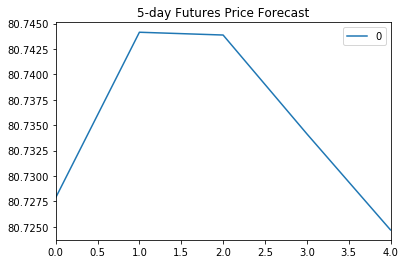

In [17]:
# Plot the 5 Day Price Forecast
pd.DataFrame(outcome1.forecast(steps=5)[0]).plot(title='5-day Futures Price Forecast')

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecasts that the Japanese Yen will drop in value over time.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
import arch as arch

In [19]:
# Estimate a GARCH model:
from arch import arch_model
model_garch = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
output_garch = model_garch.fit(disp=True)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 59311.27325094455
Iteration:      2,   Func. Count:     16,   Neg. LLF: 915737252.0393375
Iteration:      3,   Func. Count:     22,   Neg. LLF: 11059.110209998764
Iteration:      4,   Func. Count:     28,   Neg. LLF: 13278.063737854449
Iteration:      5,   Func. Count:     35,   Neg. LLF: 11115.545634221644
Iteration:      6,   Func. Count:     41,   Neg. LLF: 10868.308380914612
Iteration:      7,   Func. Count:     46,   Neg. LLF: 10871.420739477097
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10882.682865582257
Iteration:      9,   Func. Count:     58,   Neg. LLF: 10867.34901284876
Iteration:     10,   Func. Count:     63,   Neg. LLF: 10867.34500222289
Iteration:     11,   Func. Count:     68,   Neg. LLF: 10867.344856844611
Iteration:     12,   Func. Count:     73,   Neg. LLF: 10867.344847290758
Iteration:     13,   Func. Count:     77,   Neg. LLF: 10867.344847287894


In [20]:
# Summarize the model results
output_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10867.3
Distribution:                  Normal   AIC:                           21742.7
Method:            Maximum Likelihood   BIC:                           21771.5
                                        No. Observations:                 9965
Date:                Fri, Apr 30 2021   Df Residuals:                     9965
Time:                        08:30:44   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.6364e-03  2.912e-03      3.310  9.339e-04  [3.930e-03,1.534e-02]
alpha[1]       0.0675  1.661e-02      4.063  4.834e-05    [3.494e-02,  0.100]
alpha[2]   4.6028e-13  1.860e-02  2.475e-11      1.000 [-3.645e-02,3.645e-02]
beta[1]        0.9181  1.402e-02     65.490      0.000      [  0.891,  0.946]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [21]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [22]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = output_garch.forecast(start=last_day, horizon=forecast_horizon)

In [23]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.443383,12.451102,12.458704,12.466192,12.473567


In [24]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04 00:00:00
h.1,12.443383
h.2,12.451102
h.3,12.458704
h.4,12.466192
h.5,12.473567


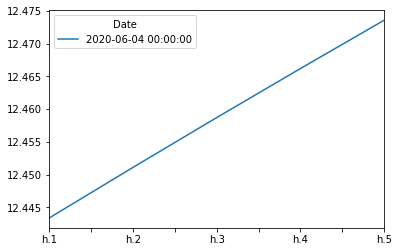

In [25]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model forecsats that volatility will continue to rise in the near term.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * No

2. Is the risk of the yen expected to increase or decrease?
    * The risk of the YEN is expected to increase with increased volatility.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * 50-50